<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/LR(Multinomial)(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading datasets...
Train data shape: (3584, 84)
Validation data shape: (768, 84)
Test data shape: (768, 84)

Creating quantile-based labels...
Quantile thresholds: [ 550.2   1447.52  3064.522 6362.6  ]

Label distribution in training set:
Very Low: 717 (20.0%)
Low: 717 (20.0%)
Medium: 716 (20.0%)
High: 717 (20.0%)
Very High: 717 (20.0%)

Preparing features...
Number of features: 83

Training Multinomial Logistic Regression for 100 iterations...
Training completed!

VALIDATION Results:
Accuracy: 0.7969
Precision (Weighted): 0.7997
Recall (Weighted): 0.7969
F1 Score (Weighted): 0.7978
F1 Score (Macro): 0.7971

TEST Results:
Accuracy: 0.7878
Precision (Weighted): 0.7892
Recall (Weighted): 0.7878
F1 Score (Weighted): 0.7882
F1 Score (Macro): 0.7851


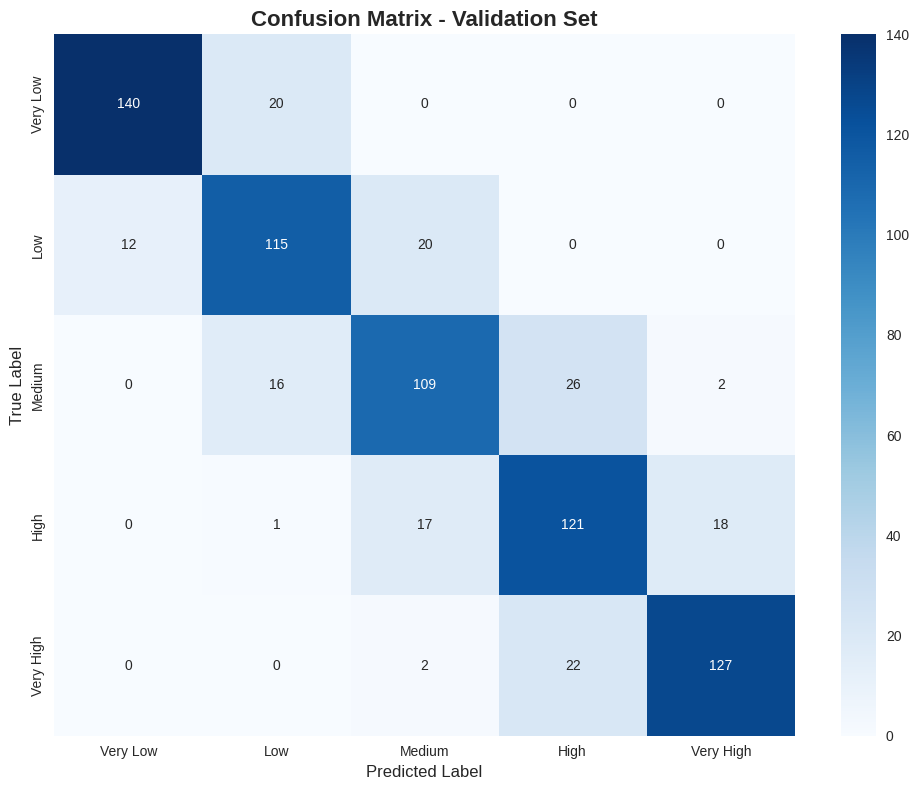

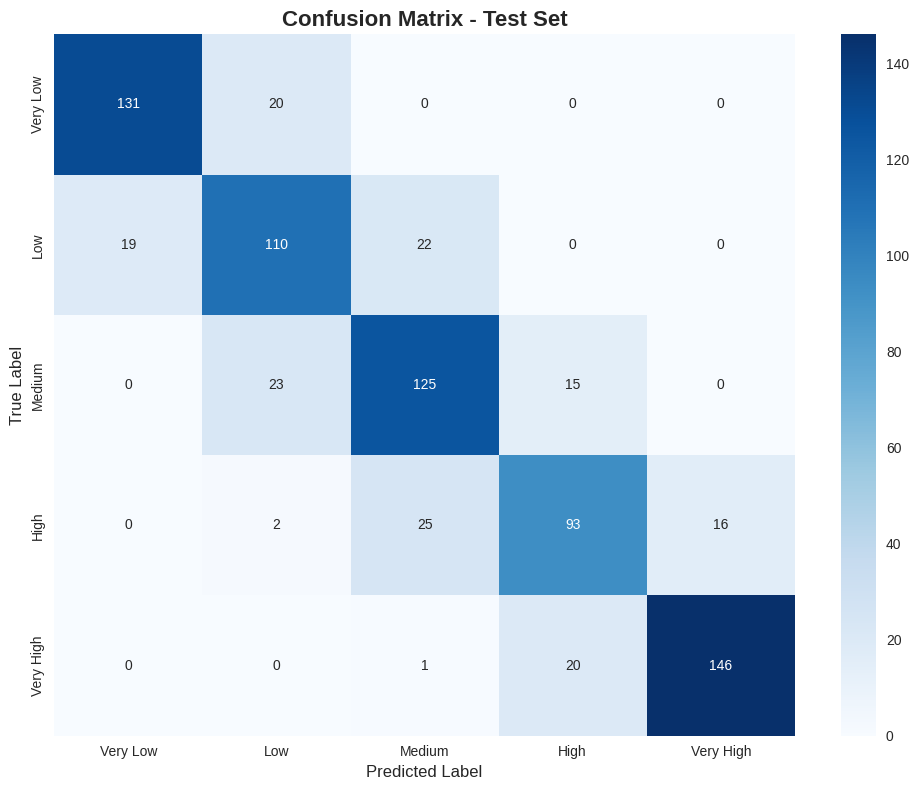

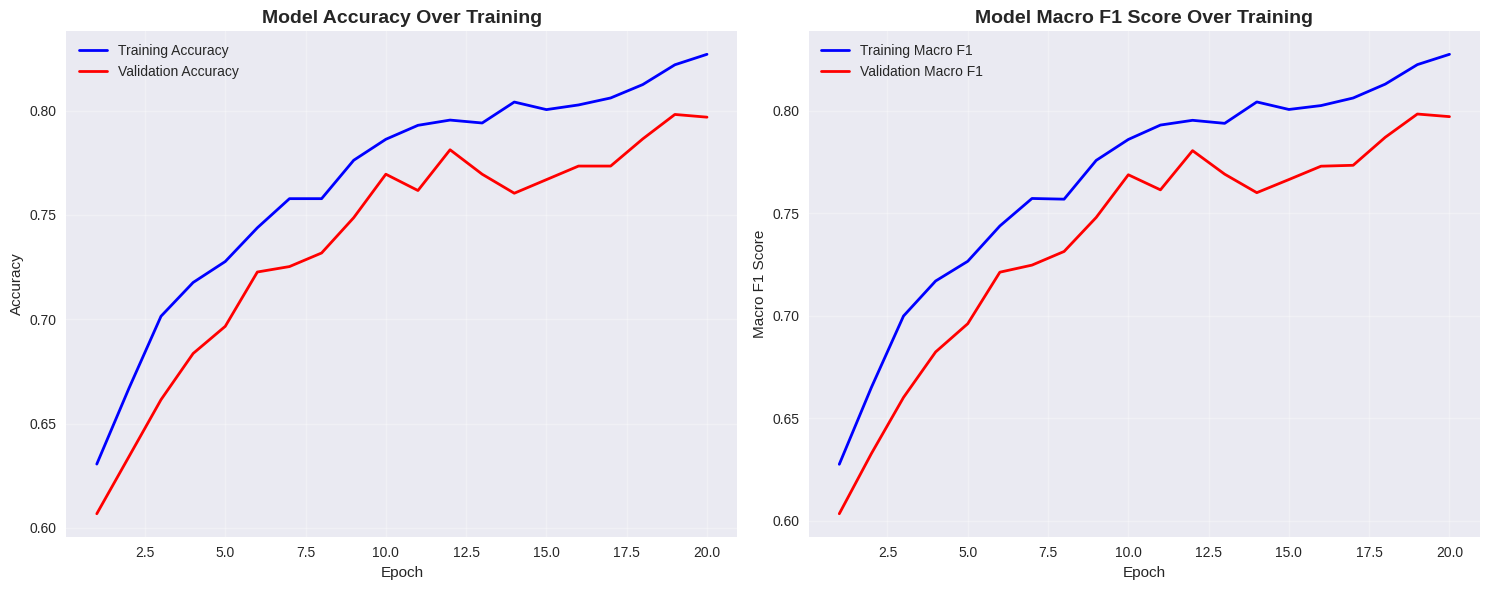


CLASSIFICATION METRICS SUMMARY
                     Validation    Test
Accuracy                 0.7969  0.7878
Precision                0.7997  0.7892
Recall                   0.7969  0.7878
F1 Score (Weighted)      0.7978  0.7882
F1 Score (Macro)         0.7971  0.7851

MODEL TRAINING COMPLETED SUCCESSFULLY!


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ProductionClassifier:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.label_mapping = {0: 'Very Low', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
        self.history = {'train_accuracy': [], 'val_accuracy': [], 'train_f1': [], 'val_f1': []}

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("Loading datasets...")

        # Load datasets
        self.train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        self.val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        self.test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"Train data shape: {self.train_df.shape}")
        print(f"Validation data shape: {self.val_df.shape}")
        print(f"Test data shape: {self.test_df.shape}")

        # Handle missing values
        for df in [self.train_df, self.val_df, self.test_df]:
            df.fillna(df.mean(numeric_only=True), inplace=True)

        return self.train_df, self.val_df, self.test_df

    def create_quantile_labels(self):
        """Create quantile-based labels for production"""
        print("\nCreating quantile-based labels...")

        # Calculate quantiles from training data
        production_col = 'Production (M.Ton)'
        quantiles = self.train_df[production_col].quantile([0.2, 0.4, 0.6, 0.8]).values

        print(f"Quantile thresholds: {quantiles}")

        def assign_label(value):
            if value <= quantiles[0]:
                return 0  # Very Low
            elif value <= quantiles[1]:
                return 1  # Low
            elif value <= quantiles[2]:
                return 2  # Medium
            elif value <= quantiles[3]:
                return 3  # High
            else:
                return 4  # Very High

        # Apply labels to all datasets
        self.y_train = self.train_df[production_col].apply(assign_label)
        self.y_val = self.val_df[production_col].apply(assign_label)
        self.y_test = self.test_df[production_col].apply(assign_label)

        # Print label distribution
        print("\nLabel distribution in training set:")
        for i, label in self.label_mapping.items():
            count = (self.y_train == i).sum()
            print(f"{label}: {count} ({count/len(self.y_train)*100:.1f}%)")

    def prepare_features(self):
        """Prepare feature matrices"""
        print("\nPreparing features...")

        # Remove target column and prepare features
        feature_cols = [col for col in self.train_df.columns if col != 'Production (M.Ton)']

        self.X_train = self.train_df[feature_cols]
        self.X_val = self.val_df[feature_cols]
        self.X_test = self.test_df[feature_cols]

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"Number of features: {self.X_train_scaled.shape[1]}")

    def train_model(self, epochs=100, C=250):
        """Train the multinomial logistic regression model"""
        print(f"\nTraining Multinomial Logistic Regression for {epochs} iterations...")

        # Initialize model
        self.model = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            C=C,
            max_iter=epochs,
            random_state=42
        )

        # Train model
        self.model.fit(self.X_train_scaled, self.y_train)

        # Calculate training and validation metrics for each iteration
        # Note: sklearn LogisticRegression doesn't provide per-iteration metrics
        # We'll simulate this by training models with increasing max_iter
        epoch_steps = max(1, epochs // 20)  # 20 evaluation points
        eval_points = range(epoch_steps, epochs + 1, epoch_steps)

        for max_iter in eval_points:
            temp_model = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                C=C,
                max_iter=max_iter,
                random_state=42
            )
            temp_model.fit(self.X_train_scaled, self.y_train)

            # Training metrics
            train_pred = temp_model.predict(self.X_train_scaled)
            train_acc = accuracy_score(self.y_train, train_pred)
            train_f1 = f1_score(self.y_train, train_pred, average='macro')

            # Validation metrics
            val_pred = temp_model.predict(self.X_val_scaled)
            val_acc = accuracy_score(self.y_val, val_pred)
            val_f1 = f1_score(self.y_val, val_pred, average='macro')

            self.history['train_accuracy'].append(train_acc)
            self.history['val_accuracy'].append(val_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_f1'].append(val_f1)

        print("Training completed!")

    def evaluate_model(self, X, y, dataset_name):
        """Evaluate model and return metrics"""
        predictions = self.model.predict(X)

        # Calculate metrics
        accuracy = accuracy_score(y, predictions)
        precision = precision_score(y, predictions, average='weighted')
        recall = recall_score(y, predictions, average='weighted')
        f1_weighted = f1_score(y, predictions, average='weighted')
        f1_macro = f1_score(y, predictions, average='macro')

        # Classification report
        report = classification_report(
            y, predictions,
            target_names=list(self.label_mapping.values()),
            output_dict=True
        )

        print(f"\n{dataset_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"F1 Score (Macro): {f1_macro:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'predictions': predictions,
            'report': report
        }

    def plot_confusion_matrix(self, y_true, y_pred, dataset_name):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=list(self.label_mapping.values()),
            yticklabels=list(self.label_mapping.values())
        )
        plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        """Plot training vs validation accuracy and F1 score"""
        epochs = range(1, len(self.history['train_accuracy']) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Accuracy plot
        ax1.plot(epochs, self.history['train_accuracy'], 'b-', label='Training Accuracy', linewidth=2)
        ax1.plot(epochs, self.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy Over Training', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # F1 Score plot
        ax2.plot(epochs, self.history['train_f1'], 'b-', label='Training Macro F1', linewidth=2)
        ax2.plot(epochs, self.history['val_f1'], 'r-', label='Validation Macro F1', linewidth=2)
        ax2.set_title('Model Macro F1 Score Over Training', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Macro F1 Score')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def create_metrics_summary(self, val_results, test_results):
        """Create a summary table of all metrics"""
        metrics_df = pd.DataFrame({
            'Validation': [
                val_results['accuracy'],
                val_results['precision'],
                val_results['recall'],
                val_results['f1_weighted'],
                val_results['f1_macro']
            ],
            'Test': [
                test_results['accuracy'],
                test_results['precision'],
                test_results['recall'],
                test_results['f1_weighted'],
                test_results['f1_macro']
            ]
        }, index=['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)', 'F1 Score (Macro)'])

        print("\n" + "="*50)
        print("CLASSIFICATION METRICS SUMMARY")
        print("="*50)
        print(metrics_df.round(4))

        return metrics_df

# Main execution
def main():
    # Initialize classifier
    classifier = ProductionClassifier()

    # Step 1: Load and preprocess data
    train_df, val_df, test_df = classifier.load_and_preprocess_data(
        '/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv', '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv', '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv'
    )

    # Step 2: Create quantile-based labels
    classifier.create_quantile_labels()

    # Step 3: Prepare features
    classifier.prepare_features()

    # Step 4: Train model
    classifier.train_model(epochs=100, C=250)

    # Step 5: Evaluate on validation set
    val_results = classifier.evaluate_model(
        classifier.X_val_scaled, classifier.y_val, "VALIDATION"
    )

    # Step 6: Evaluate on test set
    test_results = classifier.evaluate_model(
        classifier.X_test_scaled, classifier.y_test, "TEST"
    )

    # Step 7: Plot confusion matrices
    classifier.plot_confusion_matrix(
        classifier.y_val, val_results['predictions'], "Validation Set"
    )
    classifier.plot_confusion_matrix(
        classifier.y_test, test_results['predictions'], "Test Set"
    )

    # Step 8: Plot training history
    classifier.plot_training_history()

    # Step 9: Create metrics summary
    metrics_summary = classifier.create_metrics_summary(val_results, test_results)

    print("\n" + "="*50)
    print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
    print("="*50)

    return classifier, val_results, test_results, metrics_summary

# Run the complete pipeline
if __name__ == "__main__":
    classifier, val_results, test_results, metrics_summary = main()